### Loading the train and test logits/likelyhoods

In [1]:
import torch
import torch.nn.functional as F

cal_path = 'calibration_logits.pth'
test_path = 'test_logits.pth'

cal_data = torch.load(cal_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

cal_logits = cal_data["logits"] 
cal_images = cal_data["images"]  
cal_gt_masks = cal_data["masks"]    
cal_probs = F.softmax(cal_logits, dim=1)

test_logits = test_data["logits"] 
test_images = test_data["images"]  
test_gt_masks = test_data["masks"]    
test_probs = F.softmax(test_logits, dim=1)

### Obtaining Lower Bound

In [2]:
def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):
    
    assert probs.dim() == 4, "Input probabilities must be a 4D tensor."
    
    entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)  # (N, H, W)
    lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       # (N, C, H, W)

    return lower_bound

cal_lower_bound = obtain_lower_bound(cal_probs)
test_lower_bound = obtain_lower_bound(test_probs)

### Visualize distribution of likelyhood by class

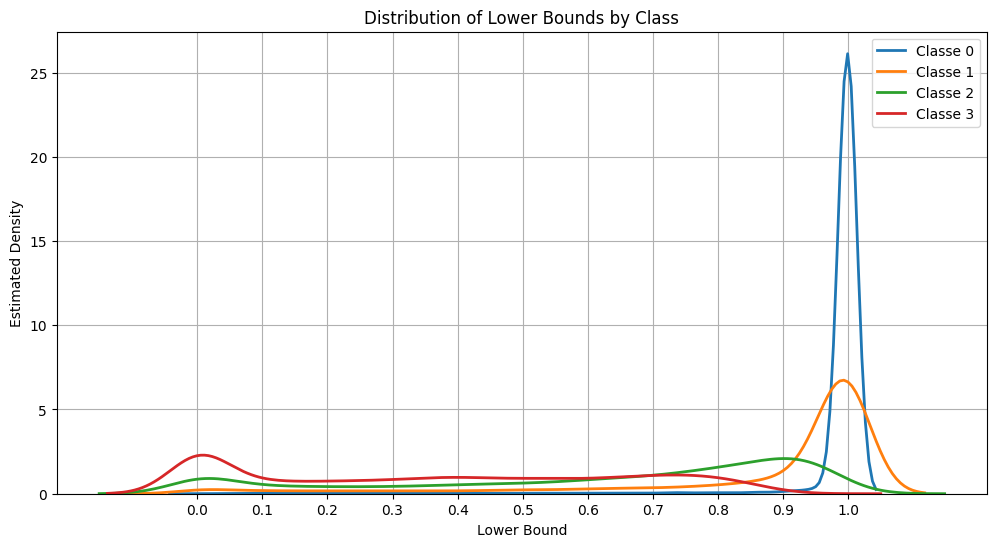

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
    
    N, C, H, W = lower_bound.shape

    plt.figure(figsize=(12, 6))

    for c in range(C):
        mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
        lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

        if lower_c.numel() > sample_size:
            indices = torch.randperm(lower_c.numel())[:sample_size]
            lower_c = lower_c[indices]

        sns.kdeplot(lower_c.cpu().numpy(), label=f'Classe {c}', linewidth=2)

    plt.title("Distribution of Lower Bounds by Class")
    plt.xlabel("Lower Bound")
    plt.ylabel("Estimated Density")
    plt.legend()
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.grid(True)
    plt.show()

plot_lower_bound_distribution(cal_lower_bound, cal_gt_masks)

### Functions

In [6]:
from sklearn.metrics import average_precision_score

def flatten_probs_labels(probs, labels):
    N, C, H, W = probs.shape
    probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
    labels_flat = labels.view(-1)  # (N*H*W,)
    return probs_flat, labels_flat

def compute_average_precision(probs, labels, num_classes=4):
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    AP_per_class = []

    for c in range(num_classes):
        # True binary labels for class c (1 if pixel == c, 0 otherwise)
        true_binary = (labels_flat == c).cpu().numpy()
        # Probabilities for class c
        prob_c = probs_flat[:, c].cpu().numpy()

        if np.sum(true_binary) == 0:
            AP_per_class.append(np.nan)  # No positive samples, skip
        else:
            AP = average_precision_score(true_binary, prob_c)
            AP_per_class.append(AP)

    # Mean AP (mAP), ignoring NaNs
    mAP = np.nanmean(AP_per_class)
    return AP_per_class, mAP

def compute_ece(probs, labels, num_bins=10):
    # Convert to numpy
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    confidences, predictions = torch.max(probs_flat, dim=1)
    confidences = confidences.cpu().numpy()
    predictions = predictions.cpu().numpy()
    labels_flat = labels_flat.cpu().numpy()

    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    ece = 0.0

    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]

        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(predictions[in_bin] == labels_flat[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece


def print_metrics(probs, labels, name=None):
    APs, mAP = compute_average_precision(probs, labels)
    ece = compute_ece(probs, labels)

    print(f"\n=== {name} ===")
    print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in APs])
    print("Mean Average Precision (mAP):", f"{mAP:.4f}")
    print("Expected Calibration Error (ECE):", f"{ece:.4f}")

### Superpixels

In [7]:
from skimage.segmentation import slic
from sklearn.cluster import KMeans
import numpy as np

def generate_superpixels(images, n_segments=100):
    N, C, H, W = images.shape
    superpixel_labels = torch.zeros((N, H, W), dtype=torch.long)

    for i in range(N):
        img = images[i].permute(1, 2, 0).cpu().numpy()

        segments = slic(img, n_segments=n_segments, compactness=10, sigma=1)

        superpixel_labels[i] = torch.tensor(segments)

    return superpixel_labels

def compute_superpixel_uncertainty(lower_bound, superpixel_labels):
    N, C, H, W = lower_bound.shape
    uncertainties = []

    for i in range(N):
        img_uncertainties = {}
        num_superpixels = torch.max(superpixel_labels[i]).item() + 1

        for sp_id in range(num_superpixels):
            mask = (superpixel_labels[i] == sp_id)

            sp_lower_bound = lower_bound[i, :, mask]
            sp_uncertainty = 1.0 - torch.max(sp_lower_bound, dim=0)[0].mean().item()

            img_uncertainties[sp_id] = sp_uncertainty

        uncertainties.append(img_uncertainties)

    return uncertainties

def dynamic_budget_superpixel_selection(uncertainties, clustering_threshold=0.5):
    uncertain_superpixels = []

    for img_uncertainties in uncertainties:
        # Filtrar superpixels com valores válidos (não NaN)
        valid_items = [(sp_id, val) for sp_id, val in img_uncertainties.items() if not np.isnan(val)]
        if not valid_items:
            uncertain_superpixels.append(set())
            continue

        valid_sp_ids, valid_uncertainties = zip(*valid_items)
        uncertainty_values = np.array(valid_uncertainties).reshape(-1, 1)

        # Aplicar K-means com k=2 para separar superpixels confiantes e incertos
        kmeans = KMeans(n_clusters=2, random_state=0).fit(uncertainty_values)
        labels = kmeans.labels_

        # Identificar o cluster com maior incerteza média
        cluster_means = [uncertainty_values[labels == i].mean() for i in range(2)]
        uncertain_cluster = np.argmax(cluster_means)

        # Selecionar superpixels do cluster incerto
        uncertain_sp_ids = set()
        for idx, sp_id in enumerate(valid_sp_ids):
            if labels[idx] == uncertain_cluster:
                uncertain_sp_ids.add(sp_id)

        uncertain_superpixels.append(uncertain_sp_ids)

    return uncertain_superpixels

def superpixel_imprecise_probs(lower_bound, superpixel_labels, uncertain_superpixels, baseline_probs):
    N, C, H, W = lower_bound.shape
    final_probs = lower_bound.clone()

    for i in range(N):
        # Criar máscara para superpixels incertos
        uncertain_mask = torch.zeros((H, W), dtype=torch.bool)
        for sp_id in uncertain_superpixels[i]:
            uncertain_mask |= (superpixel_labels[i] == sp_id)

        # Para pixels em superpixels incertos, usar probabilidades baseline
        for c in range(C):
            final_probs[i, c][uncertain_mask] = baseline_probs[i, c][uncertain_mask]

    return final_probs

superpixel_labels = generate_superpixels(test_images)

uncertainties = compute_superpixel_uncertainty(test_lower_bound, superpixel_labels)
uncertain_superpixels = dynamic_budget_superpixel_selection(uncertainties)
final_probs = superpixel_imprecise_probs(test_lower_bound, superpixel_labels, uncertain_superpixels, test_probs)

print_metrics(test_probs, test_gt_masks, name="Baseline Metrics")
print_metrics(final_probs, test_gt_masks, name="Imprecise Probability Approach Metrics")


=== Baseline Metrics ===
Average Precision per class: ['0.9997', '0.9828', '0.6978', '0.3823']
Mean Average Precision (mAP): 0.7657
Expected Calibration Error (ECE): 0.0023

=== Imprecise Probability Approach Metrics ===
Average Precision per class: ['0.9997', '0.9793', '0.6957', '0.3873']
Mean Average Precision (mAP): 0.7655
Expected Calibration Error (ECE): 0.0012
